# 전이 학습(Transfer Learning) : COVID-19를 흉부 X-ray로 탐지하기

## 🎯 학습 목표
- 전이학습의 개념과 원리를 이해한다
- 사전 훈련된 ResNet18 모델을 활용하여 COVID-19 X-ray 이미지를 분류한다
- 전이학습의 장점과 실제 적용 방법을 체험한다

## 📋 실습 개요
- **작업**: 흉부 X-ray 이미지 3클래스 분류 (Normal, Viral Pneumonia, COVID-19)
- **모델**: 사전 훈련된 ResNet18 + 커스텀 분류기
- **데이터셋**: Kaggle COVID-19 Radiography Dataset
- **데이터 규모**: COVID-19 양성 3,616장, 정상 10,192장, 바이러스성 폐렴 1,345장

## 🔄 전이학습이란?
전이학습(Transfer Learning)은 한 도메인에서 학습된 지식을 다른 도메인에 적용하는 기법입니다.

### 전이학습의 장점:
1. **적은 데이터로도 높은 성능**: 새로운 작업에 맞는 데이터가 적어도 사전 훈련된 모델의 지식을 활용
2. **빠른 훈련 시간**: 처음부터 학습하는 것보다 훨씬 빠름
3. **높은 성능**: ImageNet과 같은 대규모 데이터셋에서 학습된 특징 추출 능력 활용

### 전이학습 전략:
1. **Feature Extraction**: 사전 훈련된 가중치를 고정하고 분류기만 학습
2. **Fine-tuning**: 전체 모델을 낮은 학습률로 미세 조정

In [1]:
import os
import shutil
import random
import torch
import torchvision
from torchvision import datasets
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
# 데이터셋 다운로드 (Google Colab에서 실행)
# Kaggle COVID-19 Radiography Dataset을 사용합니다
!gdown 1ql4oc0aAKL3Aw7q-6XwfD_ZaK9bPh9Wl -O covid.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ql4oc0aAKL3Aw7q-6XwfD_ZaK9bPh9Wl
From (redirected): https://drive.google.com/uc?id=1ql4oc0aAKL3Aw7q-6XwfD_ZaK9bPh9Wl&confirm=t&uuid=15180312-774f-4fce-af54-892c3c30c710
To: /content/covid.zip
100% 1.23G/1.23G [00:18<00:00, 65.1MB/s]


In [4]:
# 압축 파일 해제
!unzip -q covid.zip -d /content/

In [5]:
# 데이터셋 구조 확인
data_dir = 'COVID-19 Radiography Database'
train_dir = os.path.join(data_dir, 'train')
val_dir  = os.path.join(data_dir, 'test')

print("📁 데이터셋 구조:")
print(f"루트 디렉토리: {os.listdir(data_dir)}")
print(f"훈련 데이터: {os.listdir(train_dir)}")
print(f"테스트 데이터: {os.listdir(val_dir)}")

# 각 클래스별 이미지 수 확인
print("\n📊 각 클래스별 이미지 수:")
for split in ['train', 'test']:
    print(f"\n{split.upper()} 데이터:")
    split_dir = os.path.join(data_dir, split)
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            image_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"  {class_name}: {image_count}장")

📁 데이터셋 구조:
루트 디렉토리: ['train', 'test']
훈련 데이터: ['covid', 'normal', 'viral']
테스트 데이터: ['covid', 'normal', 'viral']

📊 각 클래스별 이미지 수:

TRAIN 데이터:
  covid: 189장
  normal: 1311장
  viral: 1315장

TEST 데이터:
  covid: 30장
  normal: 30장
  viral: 30장


## 📊 데이터셋 구조 설명

### 클래스 구성:
- **Normal**: 정상적인 흉부 X-ray 이미지
- **Viral**: 바이러스성 폐렴 X-ray 이미지  
- **COVID**: COVID-19 감염 X-ray 이미지

### 데이터 분할:
- **Train**: 모델 학습용 데이터
- **Test**: 모델 성능 평가용 데이터

### 특징:
- 의료 영상 데이터로 전문적인 해석이 필요
- 클래스 간 시각적 차이가 미묘할 수 있음
- 전이학습이 특히 효과적인 도메인

In [6]:
# 데이터 전처리 설정
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, ToTensor, Normalize

# 학습용 데이터 변환 설정
train_transform = Compose([
    Resize(size=(224, 224)),  # 이미지 크기를 224x224로 리사이즈
    RandomHorizontalFlip(),  # 이미지를 랜덤으로 수평 뒤집기 (데이터 증강)
    ToTensor(),                       # 이미지를 텐서 형식으로 변환 (값을 0~1 범위로 정규화)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 평균/표준편차로 정규화
])

# 테스트용 데이터 변환 설정
test_transform = Compose([
    Resize(size=(224, 224)),   # 이미지 크기를 224x224로 리사이즈
    ToTensor(),                        # 이미지를 텐서 형식으로 변환
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 학습 데이터와 동일한 평균과 표준편차로 정규화
])

print("✅ 데이터 전처리 설정 완료")
print("📝 ImageNet 정규화 파라미터 사용 (사전 훈련된 모델과 호환)")

✅ 데이터 전처리 설정 완료
📝 ImageNet 정규화 파라미터 사용 (사전 훈련된 모델과 호환)


In [7]:
# datasets.ImageFolder를 사용하여 데이터셋 로드
# 이 함수는 주어진 디렉토리 경로에서 이미지 파일들을 자동으로 찾아서 레이블을 할당
print("📂 데이터셋 로딩 중...")

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), test_transform)

print(f"✅ 훈련 데이터: {len(train_data)}개 이미지")
print(f"✅ 테스트 데이터: {len(test_data)}개 이미지")
print(f"📋 클래스: {train_data.classes}")

📂 데이터셋 로딩 중...
✅ 훈련 데이터: 2816개 이미지
✅ 테스트 데이터: 90개 이미지
📋 클래스: ['covid', 'normal', 'viral']


In [8]:
batch_size = 6  # 배치 크기 설정

# 학습 데이터 로더 생성
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)  # 학습 데이터 로더, 셔플 활성화

# 테스트 데이터 로더 생성
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)  # 테스트 데이터 로더, 셔플 활성화

# 학습 및 테스트 배치 수 출력
print('Number of training batches', len(train_loader))  # 학습 데이터 배치 개수 출력
print('Number of test batches', len(test_loader))  # 테스트 데이터 배치 개수 출력

Number of training batches 470
Number of test batches 15


## 데이터 시각화

In [9]:
# 클래스 이름 가져오기 (정상, 바이러스성 폐렴, COVID-19)
class_names = train_data.classes
class_names

['covid', 'normal', 'viral']

In [10]:
# 이미지를 보여주는 함수 정의
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))  # 그래프 크기 설정

    # 각 이미지를 순회하며 표시
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])  # 1행 6열로 이미지 표시, x축과 y축 눈금 제거
        image = image.numpy().transpose((1, 2, 0))  # 텐서를 (H, W, C) 형식으로 변환하여 표시

        # 정규화 해제를 위한 평균 및 표준편차 설정
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean  # 정규화 해제
        image = np.clip(image, 0., 1.)  # 이미지 값을 0과 1 사이로 클리핑

        plt.imshow(image)  # 이미지 표시

        # 예측이 틀린 경우 레이블 색상을 빨간색으로 설정
        col = 'green'
        if preds[i] != labels[i]:  # 예측이 실제 레이블과 다르면 빨간색 설정
            col = 'red'

        # 실제 클래스 레이블과 예측 클래스 레이블 표시
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')  # 실제 클래스 레이블
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)  # 예측 클래스 레이블, 색상 지정

    plt.tight_layout()  # 레이아웃 간격 조정
    plt.show()  # 그래프 표시

torch.Size([6, 3, 224, 224]) torch.Size([6])


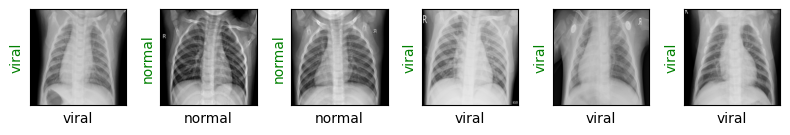

In [11]:
# 학습 데이터 로더에서 첫 번째 배치의 이미지와 레이블을 가져옴
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

# 이미지와 실제 레이블을 사용하여 이미지 표시 함수 호출 (예측 값은 실제 레이블로 설정)
show_images(images, labels, labels)  # show_images 함수는 실제 레이블을 예측 레이블로 사용하여 이미지 표시

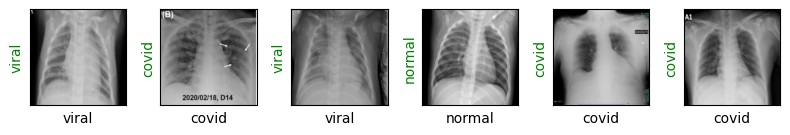

In [12]:
images, labels = next(iter(test_loader))

show_images(images, labels, labels)

## Model 생성

In [13]:
# 사전 훈련된 ResNet18 모델 로드
print("🔄 사전 훈련된 ResNet18 모델 로딩 중...")
resnet18 = torchvision.models.resnet18(pretrained=True)  # ImageNet에서 사전 훈련된 가중치 사용

print("✅ ResNet18 모델 로드 완료")
print("\n📊 모델 구조:")
print(resnet18)

# 모델 파라미터 수 확인
total_params = sum(p.numel() for p in resnet18.parameters())
trainable_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
print(f"\n📈 모델 파라미터 정보:")
print(f"  총 파라미터 수: {total_params:,}")
print(f"  학습 가능한 파라미터: {trainable_params:,}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🔄 사전 훈련된 ResNet18 모델 로딩 중...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 210MB/s]

✅ ResNet18 모델 로드 완료

📊 모델 구조:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [14]:
# 🔧 전이학습을 위한 모델 수정
print("🔧 전이학습을 위한 모델 수정 중...")

# ResNet18의 마지막 FC 레이어를 3클래스 분류에 맞게 수정
print(f"  기존 FC 레이어: {resnet18.fc}")
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)  # 3클래스: normal, viral, covid
print(f"  수정된 FC 레이어: {resnet18.fc}")

# 모델을 GPU로 이동
resnet18.to(device)
print(f"✅ 모델을 {device}로 이동 완료")

# 손실 함수와 옵티마이저 설정
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)  # 낮은 학습률로 미세 조정

print("✅ 손실 함수: CrossEntropyLoss")
print("✅ 옵티마이저: Adam (학습률: 3e-5)")

# 수정된 모델의 파라미터 수 확인
total_params = sum(p.numel() for p in resnet18.parameters())
trainable_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
print(f"\n📈 수정된 모델 파라미터 정보:")
print(f"  총 파라미터 수: {total_params:,}")
print(f"  학습 가능한 파라미터: {trainable_params:,}")
print(f"  학습률: 3e-5 (전이학습에 적합한 낮은 학습률)")

🔧 전이학습을 위한 모델 수정 중...
  기존 FC 레이어: Linear(in_features=512, out_features=1000, bias=True)
  수정된 FC 레이어: Linear(in_features=512, out_features=3, bias=True)
✅ 모델을 cuda:0로 이동 완료
✅ 손실 함수: CrossEntropyLoss
✅ 옵티마이저: Adam (학습률: 3e-5)

📈 수정된 모델 파라미터 정보:
  총 파라미터 수: 11,178,051
  학습 가능한 파라미터: 11,178,051
  학습률: 3e-5 (전이학습에 적합한 낮은 학습률)


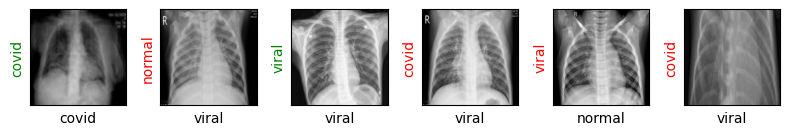

In [15]:
# 예측 결과를 시각화하는 함수 정의
def show_preds():
    resnet18.eval()  # 모델을 평가 모드로 설정

    images, labels = next(iter(test_loader))  # 테스트 데이터 로더에서 첫 번째 배치의 이미지와 레이블 가져오기
    images = images.to(device)  # 이미지를 GPU로 이동

    outputs = resnet18(images)  # 모델을 사용하여 예측 결과 생성
    _, preds = torch.max(outputs, 1)  # 예측 결과 중 가장 높은 확률을 가진 클래스 인덱스 선택

    show_images(images.cpu(), labels, preds.cpu())  # 실제 레이블과 예측 레이블을 사용하여 이미지 표시

# 예측 결과 시각화 함수 호출
show_preds()

## Model 학습

🚀 전이학습 시작!
📊 학습 설정: 3 에포크, 배치 크기: 6

📈 에포크 1/3 시작
  Step 0/470: Loss = 1.3699
  Step 50/470: Loss = 0.4444
  Step 100/470: Loss = 0.2398
  Step 150/470: Loss = 0.2264
  Step 200/470: Loss = 0.4549
  Step 250/470: Loss = 0.4525
  Step 300/470: Loss = 0.0242
  Step 350/470: Loss = 0.0154
  Step 400/470: Loss = 0.0199
  Step 450/470: Loss = 0.2627

📊 에포크 1 결과:
  훈련 손실: 0.2862
  훈련 정확도: 90.16%
  검증 손실: 0.1022
  검증 정확도: 95.56%

🔍 예측 결과 시각화:


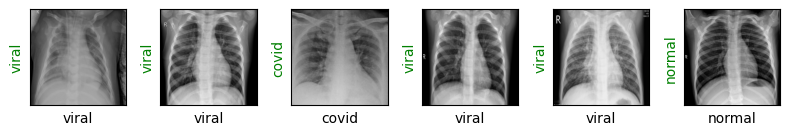


📈 에포크 2/3 시작
  Step 0/470: Loss = 0.4439
  Step 50/470: Loss = 0.1414
  Step 100/470: Loss = 0.0718
  Step 150/470: Loss = 0.0461
  Step 200/470: Loss = 0.0960
  Step 250/470: Loss = 0.3732
  Step 300/470: Loss = 0.0532
  Step 350/470: Loss = 0.0347
  Step 400/470: Loss = 0.0661
  Step 450/470: Loss = 0.0155

📊 에포크 2 결과:
  훈련 손실: 0.1720
  훈련 정확도: 94.28%
  검증 손실: 0.0801
  검증 정확도: 96.67%

🔍 예측 결과 시각화:


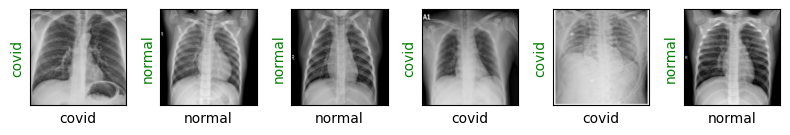


📈 에포크 3/3 시작
  Step 0/470: Loss = 0.0754
  Step 50/470: Loss = 0.0164
  Step 100/470: Loss = 0.0523
  Step 150/470: Loss = 0.0101
  Step 200/470: Loss = 0.0229
  Step 250/470: Loss = 0.0085
  Step 300/470: Loss = 0.3982
  Step 350/470: Loss = 0.0991
  Step 400/470: Loss = 0.0188
  Step 450/470: Loss = 0.1093

📊 에포크 3 결과:
  훈련 손실: 0.1017
  훈련 정확도: 97.16%
  검증 손실: 0.1112
  검증 정확도: 95.56%

🔍 예측 결과 시각화:


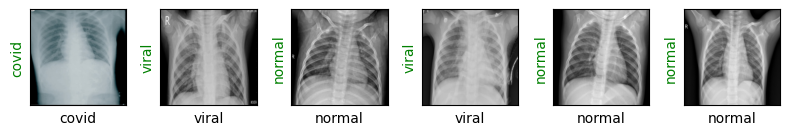


✅ 전이학습 완료!
🎯 최종 검증 정확도: 95.56%


In [16]:
# 🚀 모델 학습 시작
epochs = 3  # 학습 에포크 수 (교재용으로 적절한 수준)
print('🚀 전이학습 시작!')
print(f'📊 학습 설정: {epochs} 에포크, 배치 크기: {batch_size}')

# 학습 과정 추적을 위한 리스트
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    print('\n' + '='*50)
    print(f'📈 에포크 {epoch + 1}/{epochs} 시작')
    print('='*50)

    # 훈련 단계
    resnet18.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # 순전파
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = loss_fn(outputs, labels)

        # 역전파
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # 훈련 정확도 계산
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # 진행 상황 출력
        if step % 50 == 0:
            print(f'  Step {step}/{len(train_loader)}: Loss = {loss.item():.4f}')

    # 훈련 결과 계산
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)

    # 검증 단계
    resnet18.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.inference_mode():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # 검증 결과 계산
    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # 에포크 결과 출력
    print(f'\n📊 에포크 {epoch + 1} 결과:')
    print(f'  훈련 손실: {avg_train_loss:.4f}')
    print(f'  훈련 정확도: {train_accuracy:.2f}%')
    print(f'  검증 손실: {avg_val_loss:.4f}')
    print(f'  검증 정확도: {val_accuracy:.2f}%')

    # 예측 결과 시각화
    print('\n🔍 예측 결과 시각화:')
    show_preds()

print('\n✅ 전이학습 완료!')
print(f'🎯 최종 검증 정확도: {val_accuracies[-1]:.2f}%')

📊 최종 모델 성능 평가


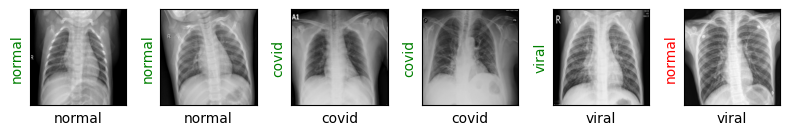

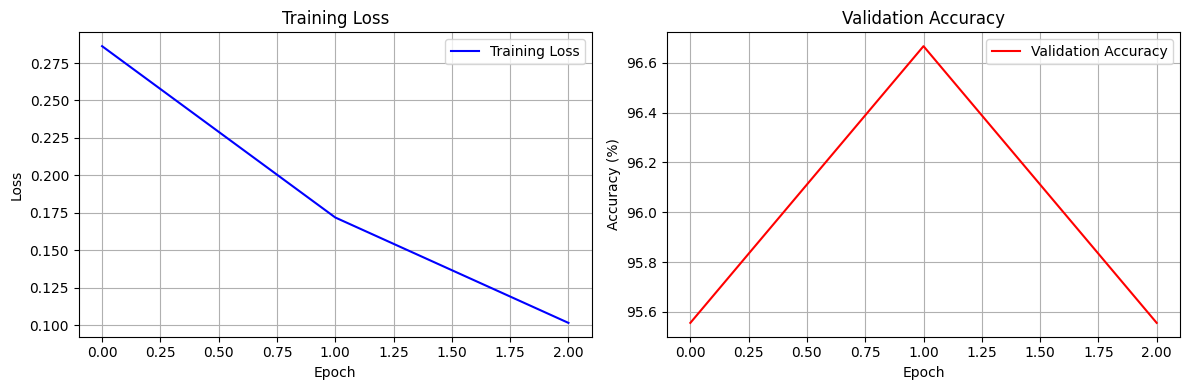


🔍 상세 성능 분석:
  최고 검증 정확도: 96.67%
  최종 검증 정확도: 95.56%
  정확도 개선: 0.00%p


In [17]:
# 📊 학습 결과 분석 및 시각화
print("📊 최종 모델 성능 평가")
show_preds()

# 학습 곡선 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 상세 성능 분석
print("\n🔍 상세 성능 분석:")
print(f"  최고 검증 정확도: {max(val_accuracies):.2f}%")
print(f"  최종 검증 정확도: {val_accuracies[-1]:.2f}%")
print(f"  정확도 개선: {val_accuracies[-1] - val_accuracies[0]:.2f}%p")

🔍 상세 모델 평가 중...


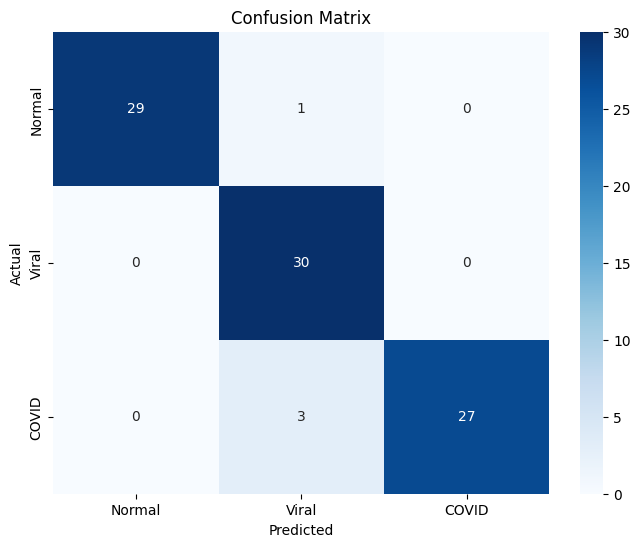


📋 분류 보고서:
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98        30
       Viral       0.88      1.00      0.94        30
       COVID       1.00      0.90      0.95        30

    accuracy                           0.96        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90


📊 클래스별 성능 분석:
  Normal: 0.967 (29/30)
  Viral: 1.000 (30/30)
  COVID: 0.900 (27/30)


In [18]:
# 🔍 혼동 행렬(Confusion Matrix) 분석
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model_detailed(model, test_loader):
    """모델의 상세 성능을 평가하는 함수"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# 모델 평가
print("🔍 상세 모델 평가 중...")
true_labels, predictions = evaluate_model_detailed(resnet18, test_loader)

# 혼동 행렬 생성
cm = confusion_matrix(true_labels, predictions)
class_names = ['Normal', 'Viral', 'COVID']

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 분류 보고서 출력
print("\n📋 분류 보고서:")
print(classification_report(true_labels, predictions, target_names=class_names))

# 클래스별 정확도 분석
print("\n📊 클래스별 성능 분석:")
for i, class_name in enumerate(class_names):
    class_accuracy = cm[i, i] / cm[i, :].sum()
    print(f"  {class_name}: {class_accuracy:.3f} ({cm[i, i]}/{cm[i, :].sum()})")
